In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from hiive.mdptoolbox import example, mdp 
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(36)

In [3]:
HOLE_STATE_MAP = {"4x4": [5, 7, 11, 12], "8x8": [19, 29, 35, 41, 42, 46, 49, 52, 54, 59]}
GOAL_STATE_MAP = {"4x4": [15], "8x8": [63]}

In [4]:
def reward_prob(env):
    rows = env.nrow
    cols = env.ncol
    r = np.zeros((4,rows*cols,rows*cols))
    p = np.zeros((4,rows*cols,rows*cols))
    env_P = env.unwrapped.P
    old_state = np.inf
    for state in env_P:
        for action in env_P[state]:
            for idx in range((len(env_P[state][action]))):
                trans_prob = env_P[state][action][idx][0]                
                next_state = env_P[state][action][idx][1]
                reward = env_P[state][action][idx][2]
                if next_state == old_state:
                    p[action][state][next_state] = p[action][state][old_state] + trans_prob
                    r[action][state][next_state] = r[action][state][old_state] + reward
                else:
                    p[action][state][next_state] = trans_prob
                    r[action][state][next_state] = reward
                old_state = next_state
            p[action,state,:] /= np.sum(p[action,state,:])
    return r, p

In [5]:
def plot_env(env, name, title=None):
    shape = env.desc.shape
    M = shape[0]
    N = shape[1]
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) == 0:
                arr[i, j] = 0.6
            elif (N * i + j) in HOLE_STATE_MAP[name]:
                arr[i, j] = 0.3
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(arr, cmap='coolwarm')
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='k', linewidth=1)

    for i in range(M):
        for j in range(N):
            if (i, j) == (0, 0):
                ax.text(j, i, 'S', ha='center', va='center', color='k', size=14) # start
            elif (N * i + j) in HOLE_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=14) # hole
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=14) # goal
            else:
                ax.text(j, i, 'F', ha='center', va='center', color='k', size=14) # frozen
    if title:
        ax.set_title(title)
    plt.show()

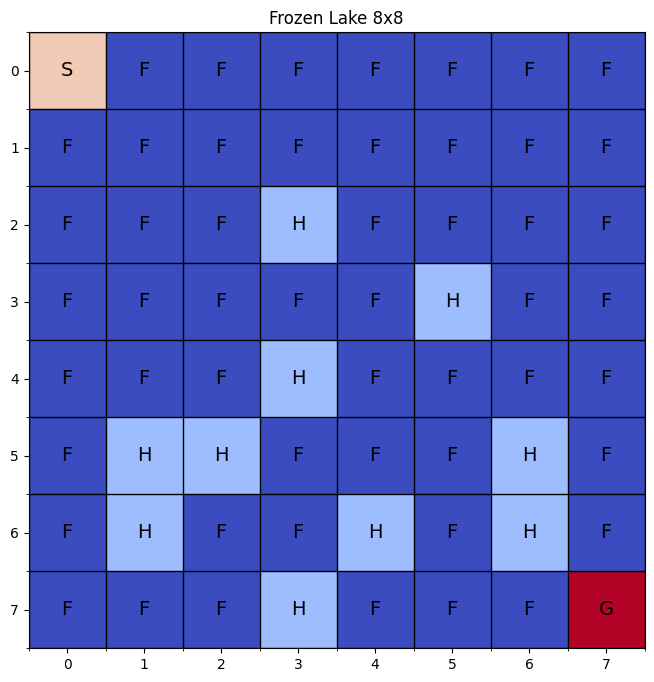

In [6]:
env = gym.make("FrozenLake-v1", map_name="8x8")
env.reset()
env.render()
plot_env(env, "8x8", "Frozen Lake 8x8")

In [7]:
def plot_value(V, shape, name, title=None):
    V = np.asarray(V)
    M = shape[0]  # shape: tuple (nrow, ncol)
    N = shape[1]
    fig, ax = plt.subplots(figsize=(8,8))
    arr = V.reshape(shape)
    im = ax.imshow(arr, cmap='coolwarm')
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='k', linewidth=1)
    for i in range(M):
        for j in range(N):
            if (N * i + j) in HOLE_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', fontsize=14)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', fontsize=14)
            else:
                ax.text(j, i, '%.2f' % (arr[i, j]), ha='center', va='center', color='k', fontsize=14)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('State-value estimate', rotation=-90, va="bottom")
    if title:
        ax.set_title(title)
    plt.show()

In [8]:
def plot_policy(policy, shape, name, title=None):
    M = shape[0]
    N = shape[1]
    actions = np.asarray(policy).reshape(shape)
    mapping = {
        0: '←',
        1: '↓',
        2: '→',
        3: '↑'
    }
    arr = np.zeros(shape)
    for i in range(M):
        for j in range(N):
            if (N * i + j) == 0:
                arr[i, j] = 0.6
            elif (N * i + j) in HOLE_STATE_MAP[name]:
                arr[i, j] = 0.3
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                arr[i, j] = 1.0
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(arr, cmap='coolwarm')
    ax.set_xticks(np.arange(M))
    ax.set_yticks(np.arange(N))
    ax.set_xticklabels(np.arange(M))
    ax.set_yticklabels(np.arange(N))
    ax.set_xticks(np.arange(-0.5, M, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, N, 1), minor=True)
    ax.grid(False)
    ax.grid(which='minor', color='w', linewidth=2)

    for i in range(M):
        for j in range(N):
            if (N * i + j) in HOLE_STATE_MAP[name]:
                ax.text(j, i, 'H', ha='center', va='center', color='k', size=14)
            elif (N * i + j) in GOAL_STATE_MAP[name]:
                ax.text(j, i, 'G', ha='center', va='center', color='k', size=14)
            else:
                ax.text(j, i, mapping[actions[i, j]], ha='center', va='center', color='k', size=14)
    if title:
        ax.set_title(title)
    plt.show()

In [9]:
gammas   = [0.3, 0.6, 0.9, 0.99]
epsilons = [1e-2, 1e-4, 1e-6, 1e-8]

gamma = 0.30, epsilon = 1.00e-02, iter = 3


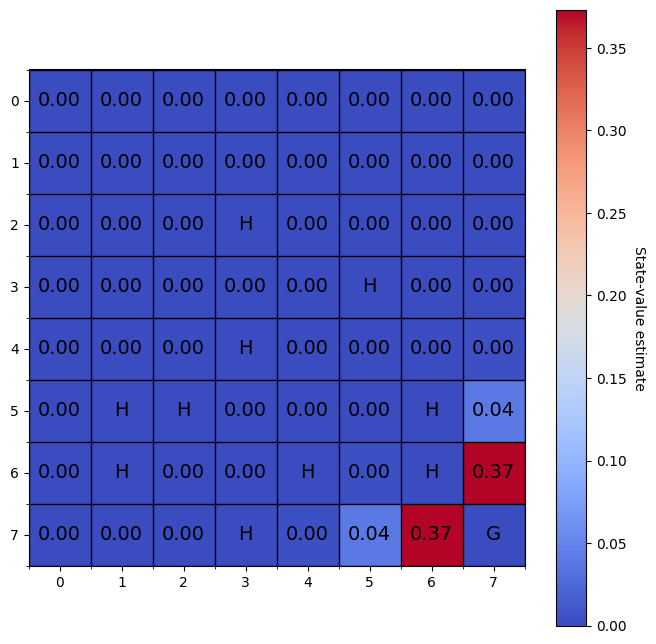

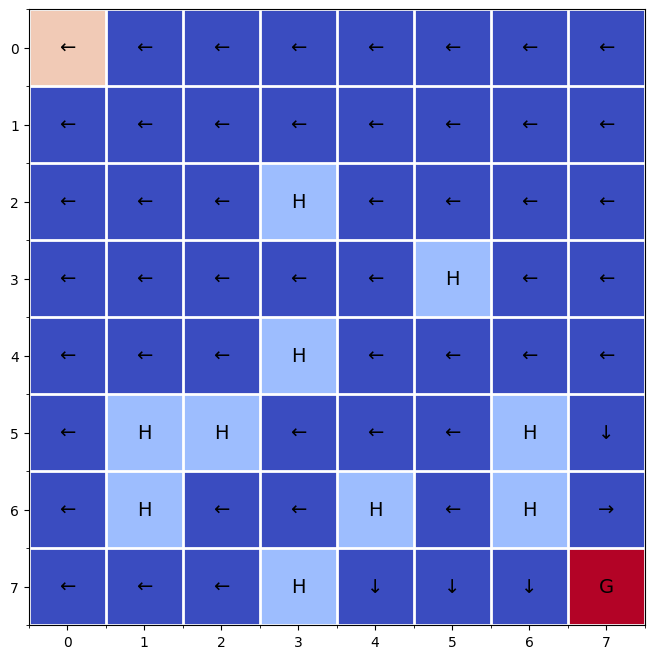

gamma = 0.30, epsilon = 1.00e-04, iter = 6


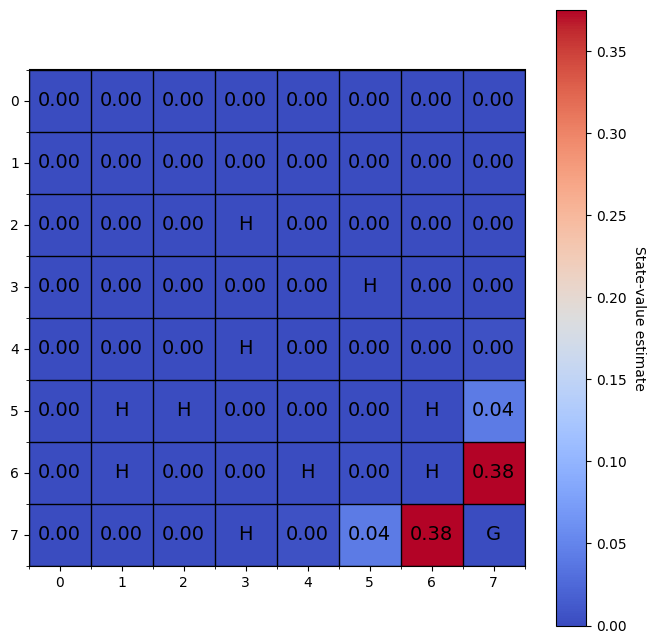

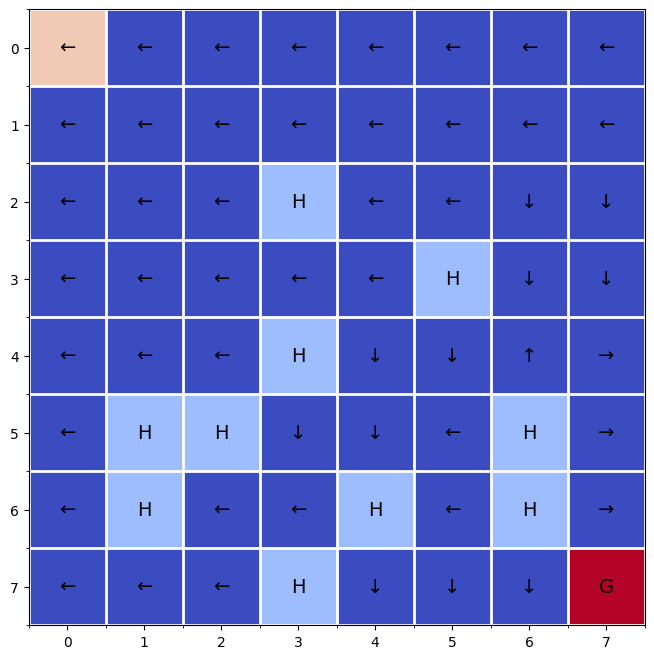

gamma = 0.30, epsilon = 1.00e-06, iter = 9


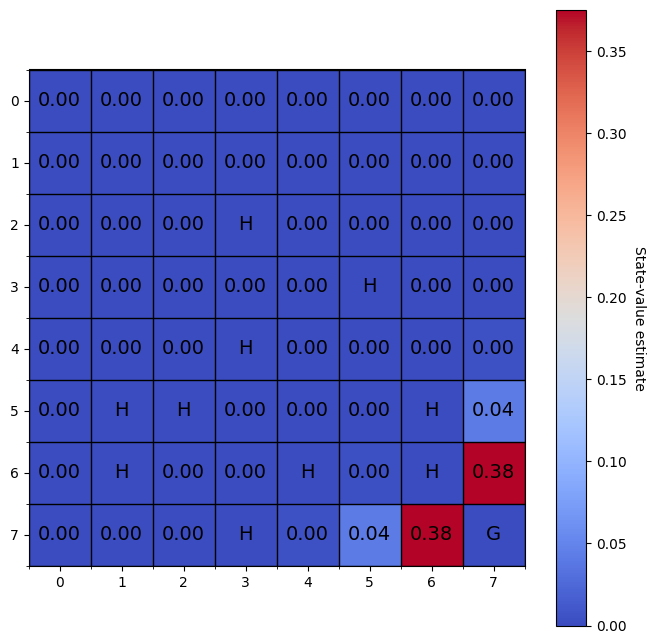

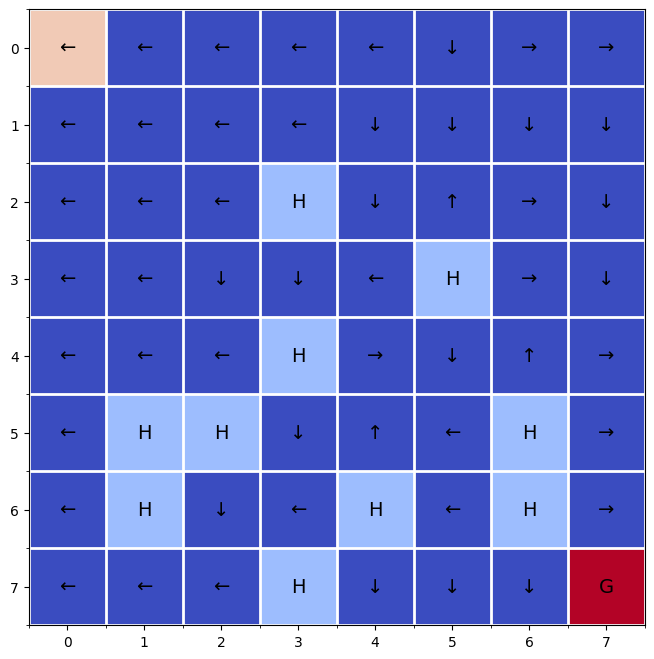

gamma = 0.30, epsilon = 1.00e-08, iter = 13


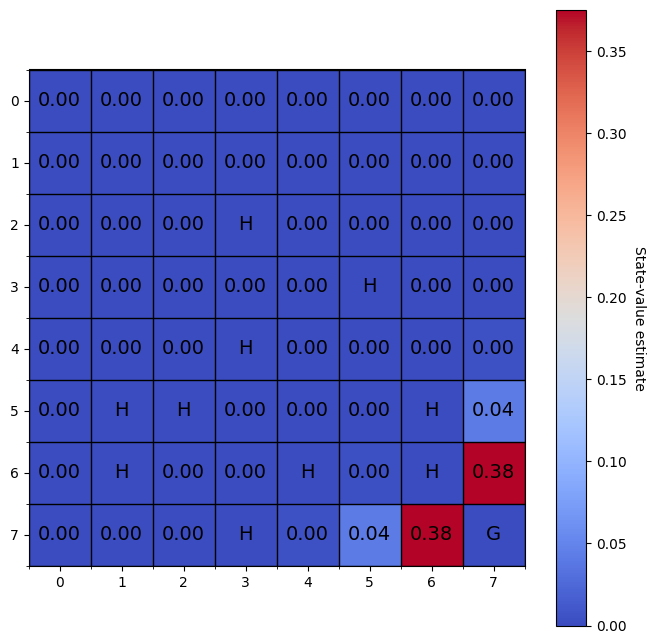

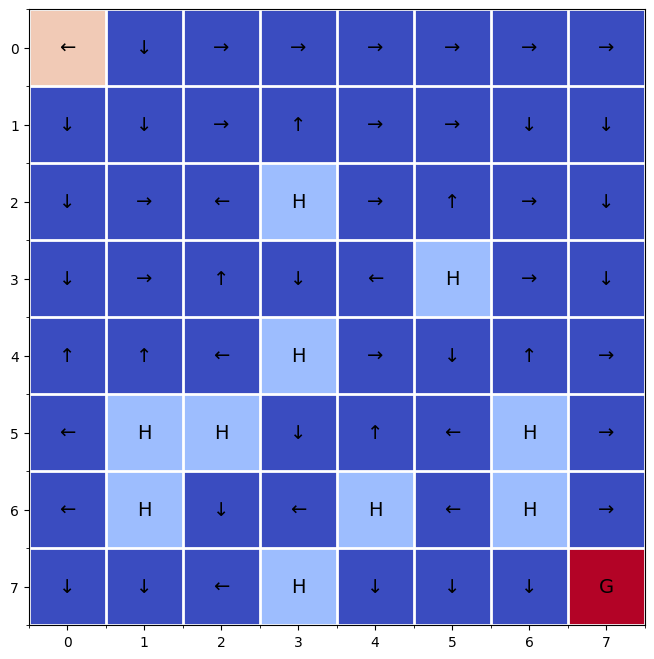

gamma = 0.60, epsilon = 1.00e-02, iter = 5


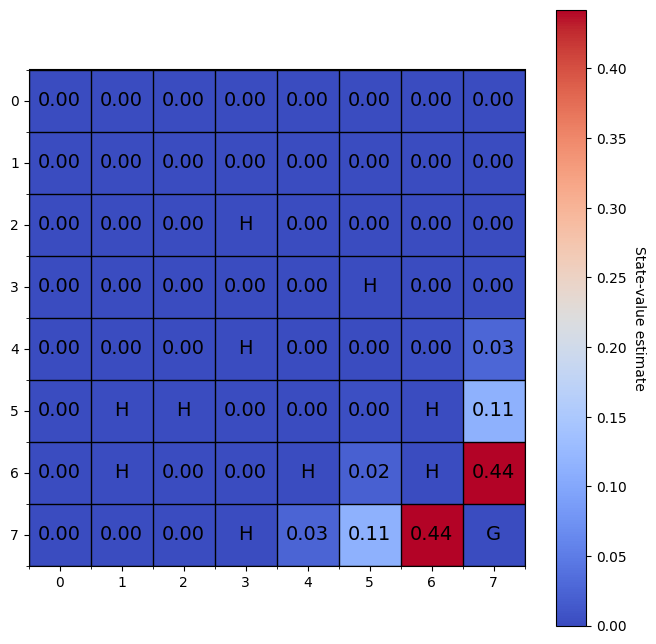

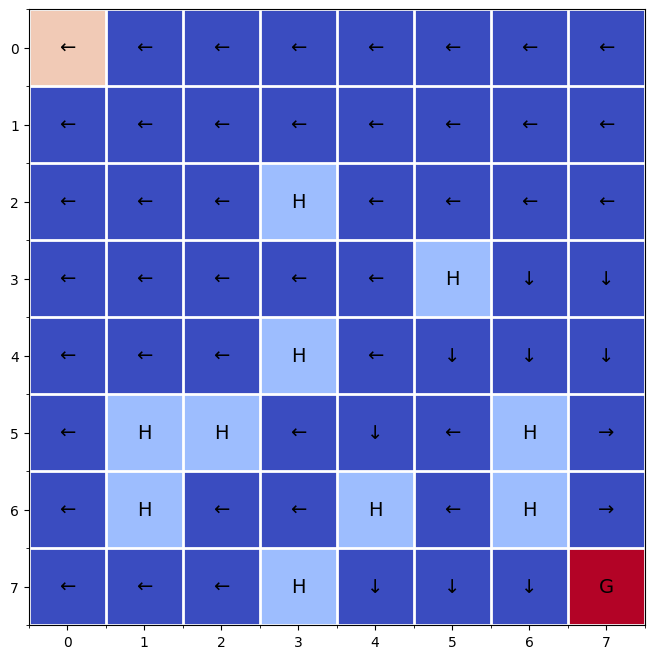

gamma = 0.60, epsilon = 1.00e-04, iter = 13


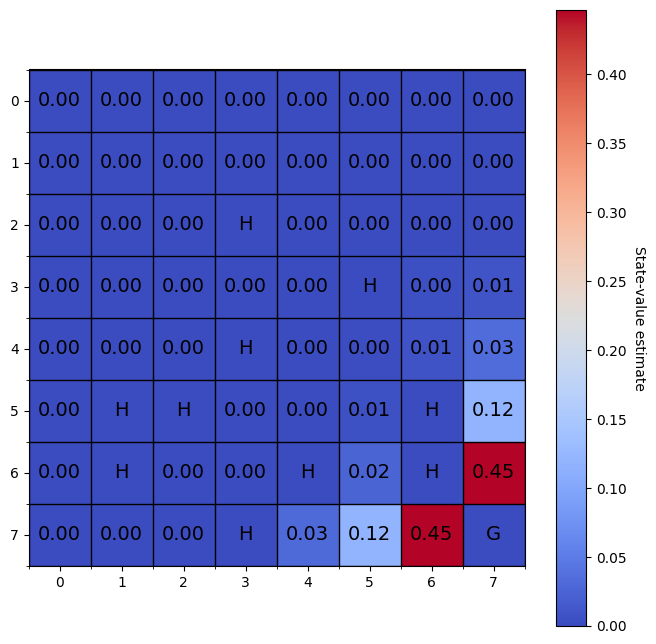

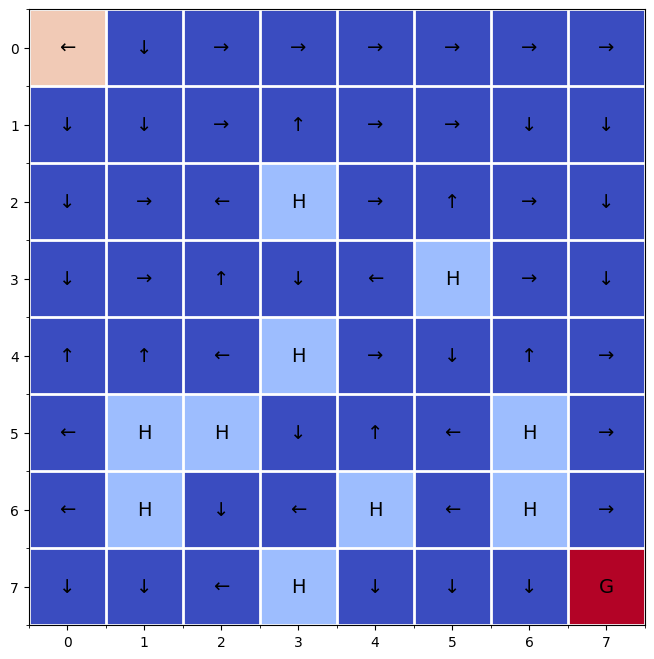

gamma = 0.60, epsilon = 1.00e-06, iter = 21


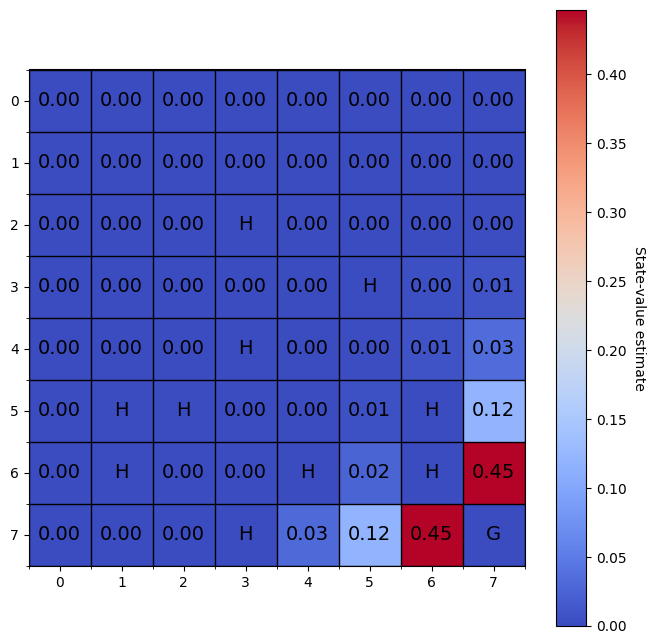

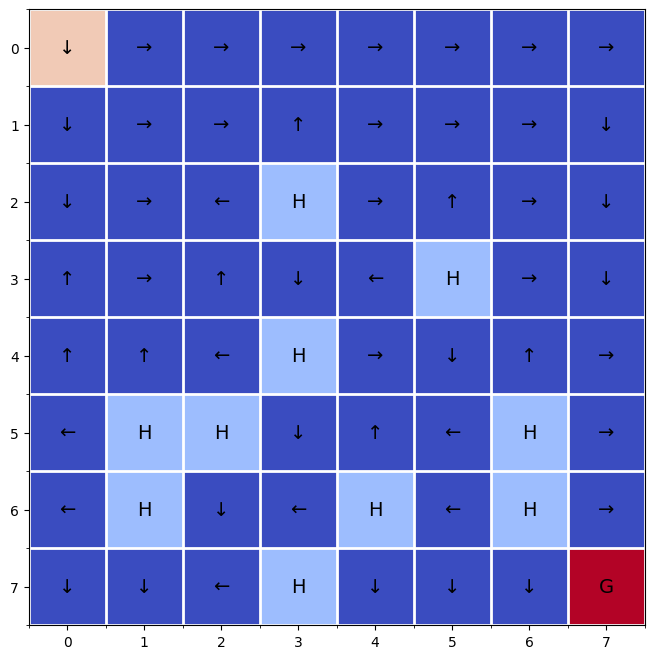

gamma = 0.60, epsilon = 1.00e-08, iter = 30


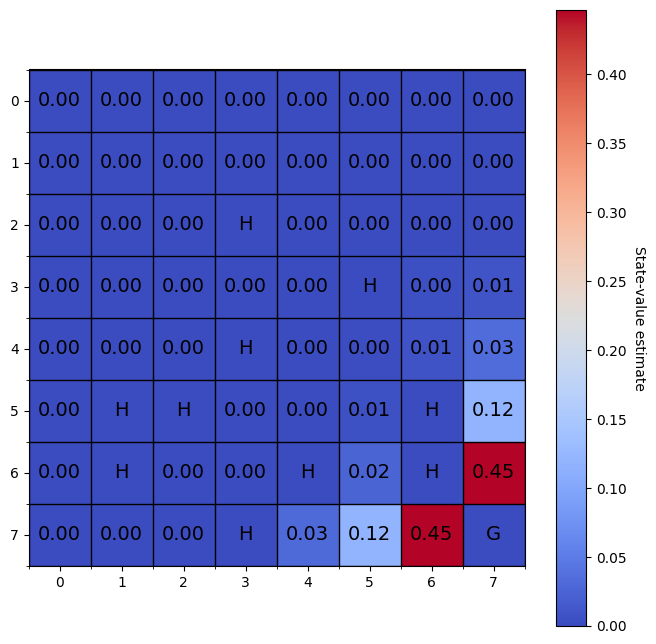

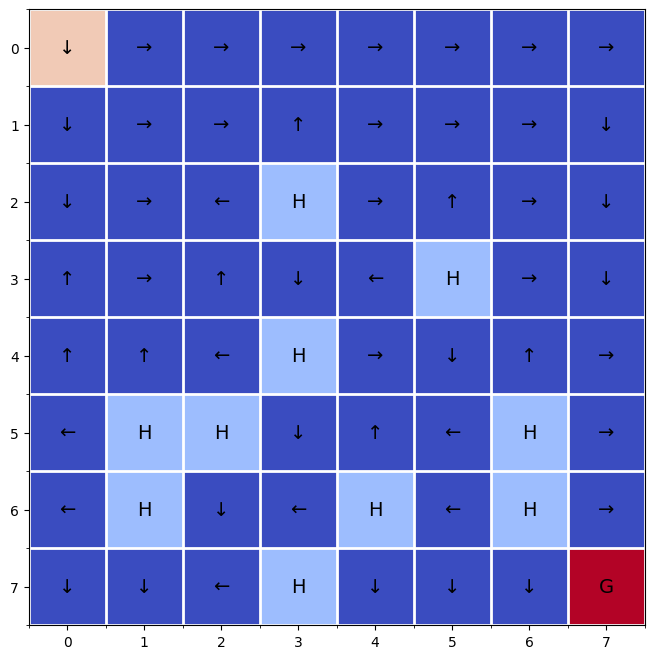

gamma = 0.90, epsilon = 1.00e-02, iter = 26


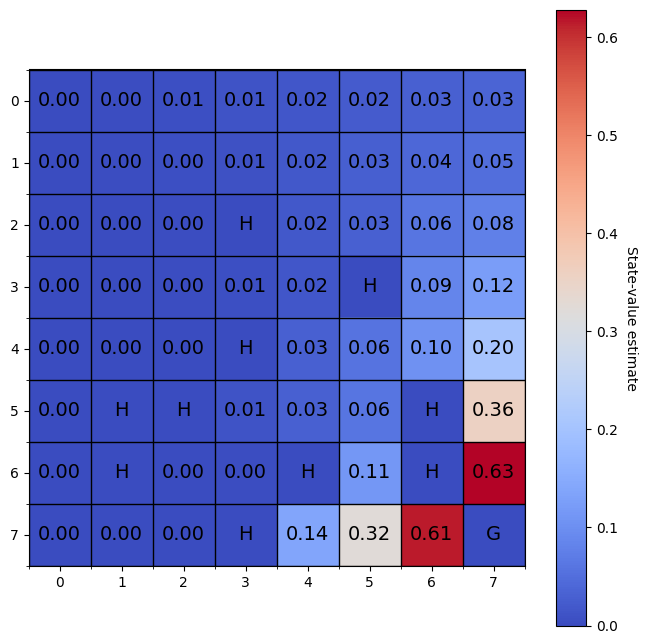

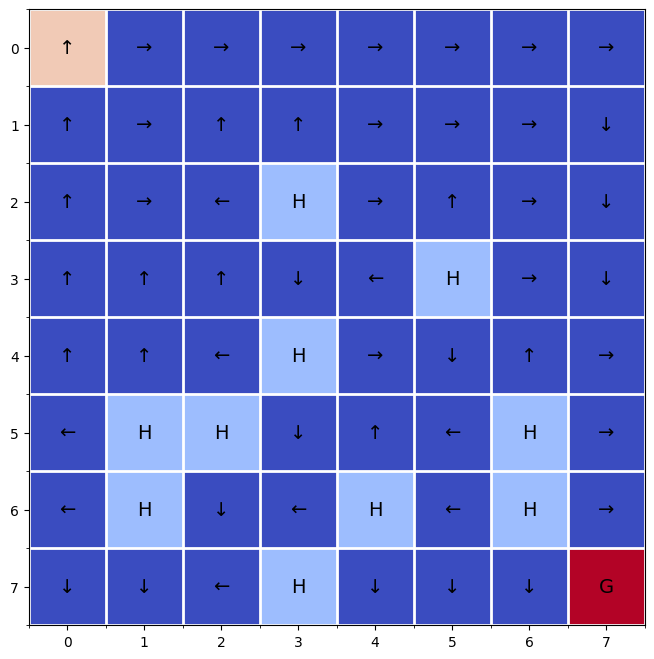

gamma = 0.90, epsilon = 1.00e-04, iter = 65


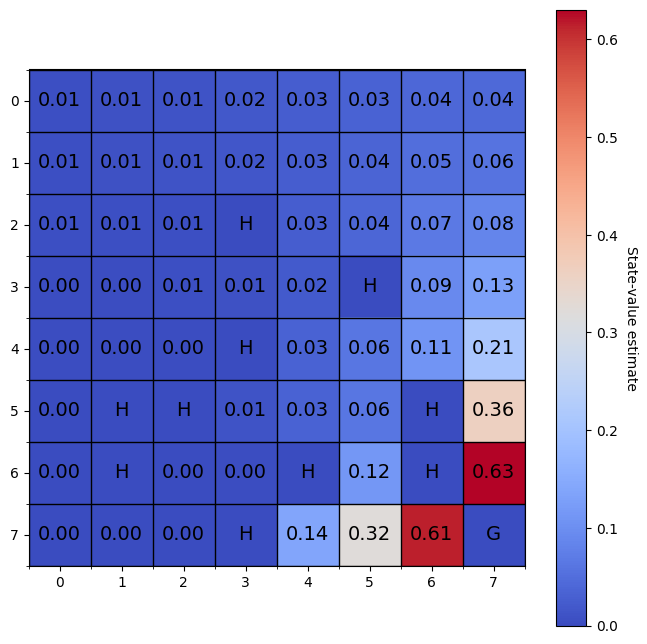

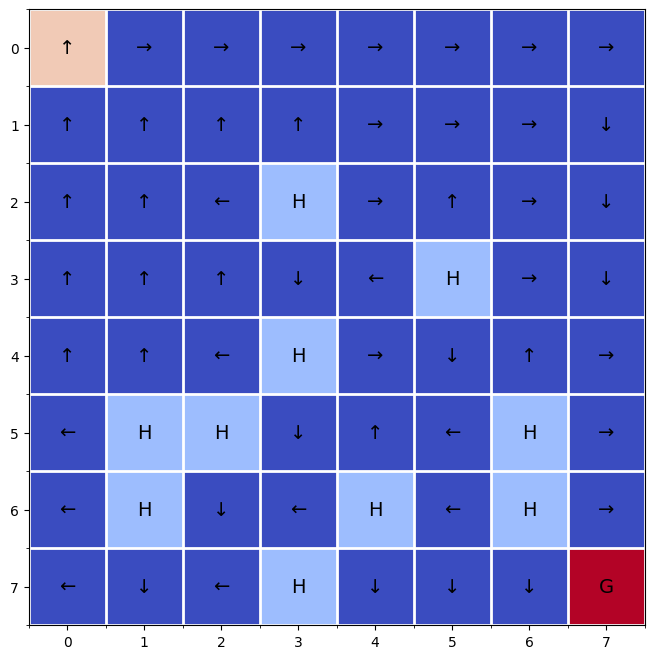

gamma = 0.90, epsilon = 1.00e-06, iter = 104


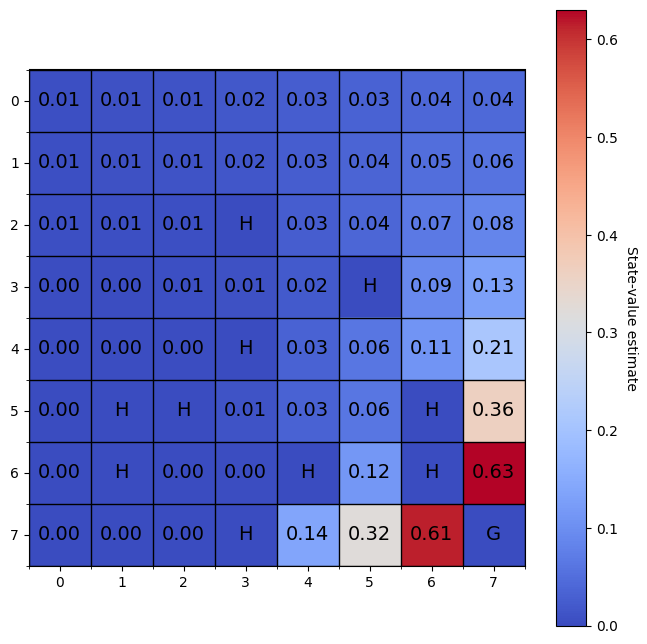

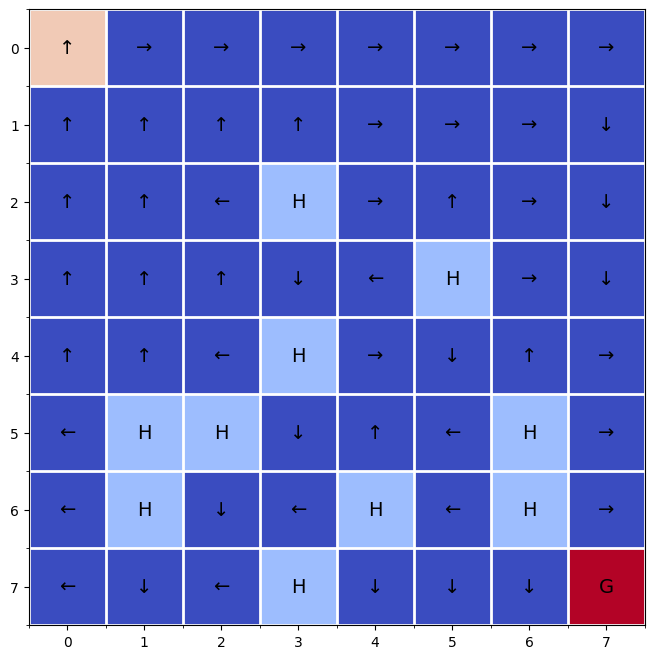

gamma = 0.90, epsilon = 1.00e-08, iter = 140


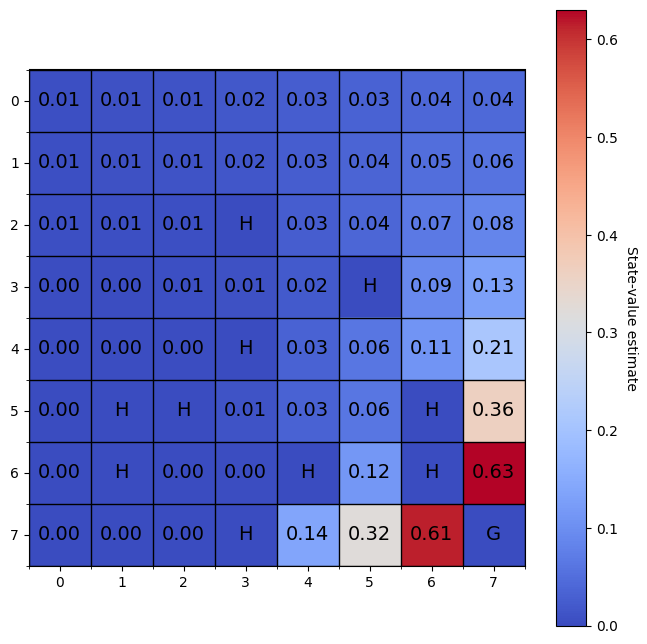

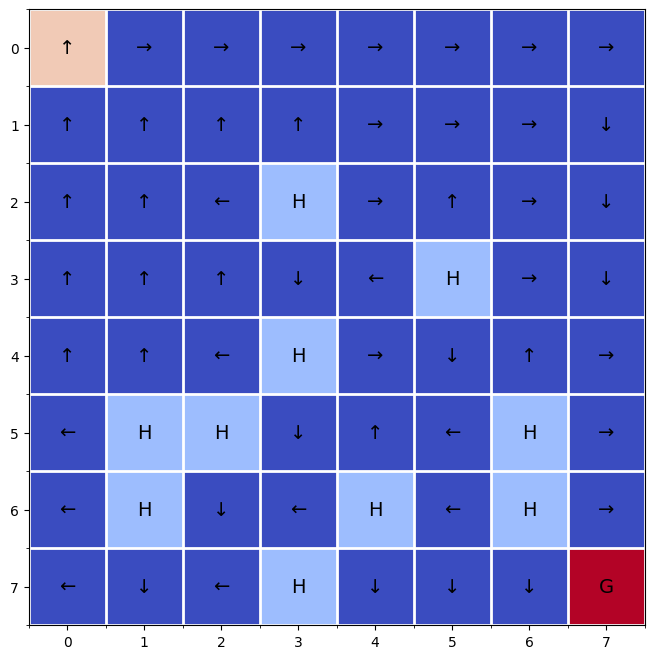

gamma = 0.99, epsilon = 1.00e-02, iter = 221


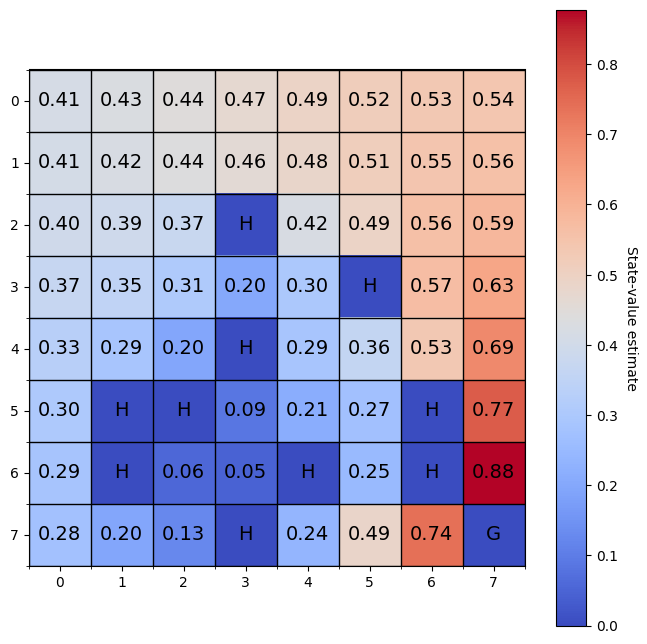

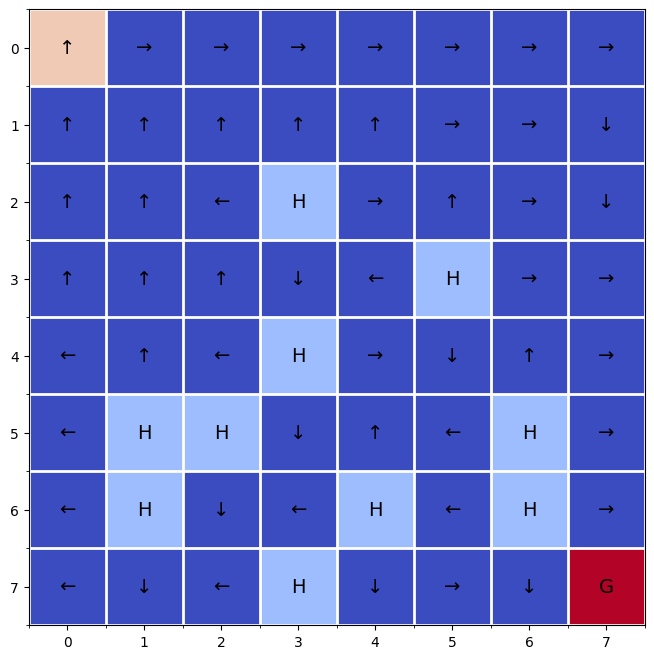

gamma = 0.99, epsilon = 1.00e-04, iter = 369


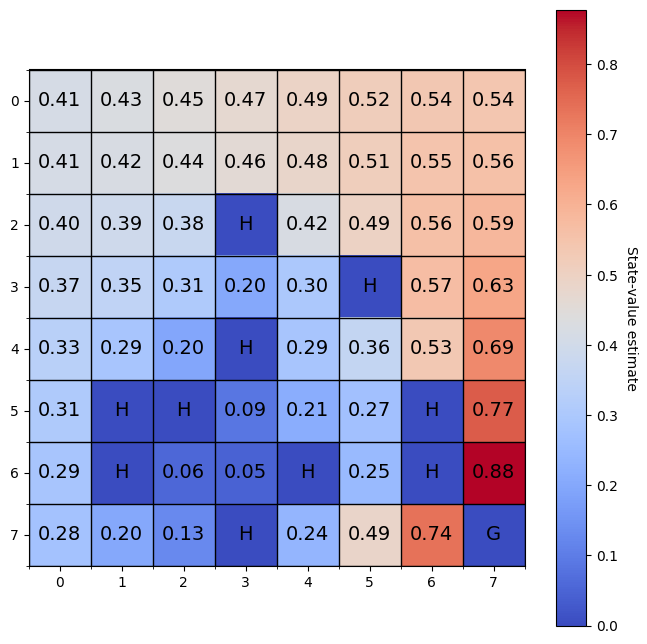

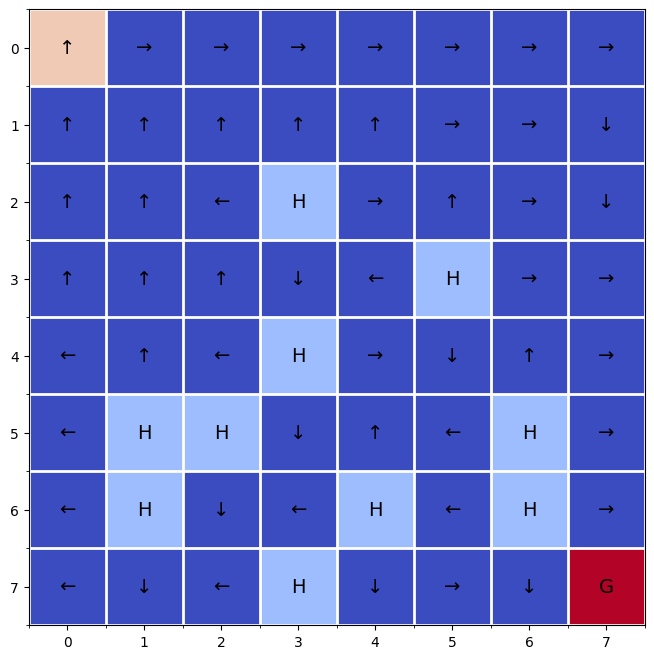

gamma = 0.99, epsilon = 1.00e-06, iter = 516


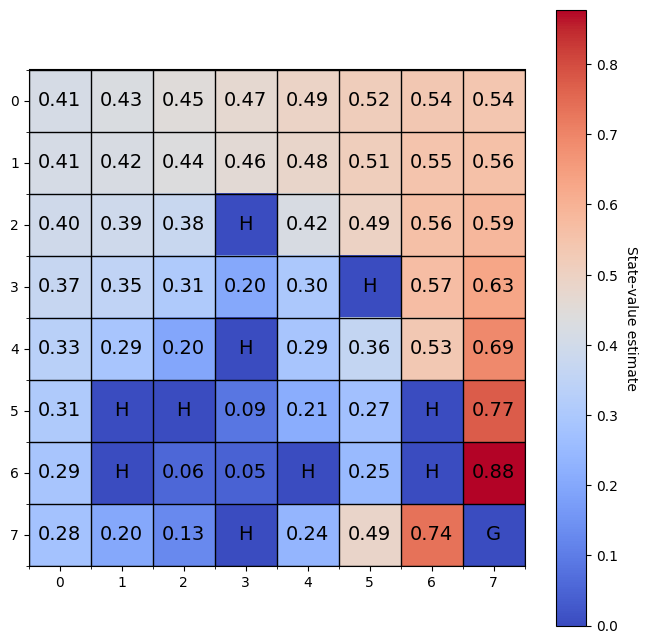

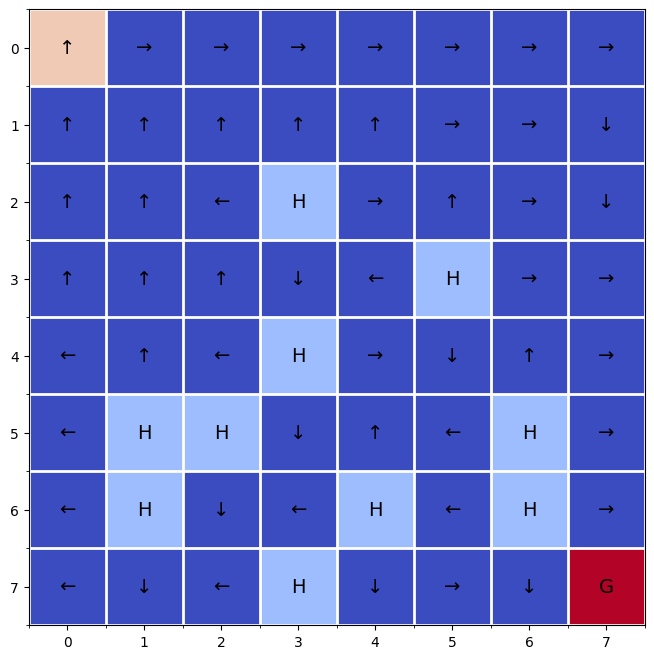

gamma = 0.99, epsilon = 1.00e-08, iter = 662


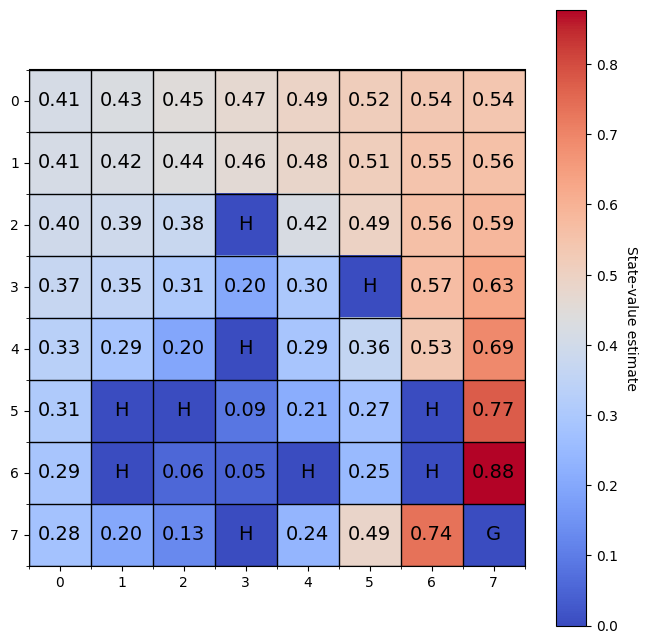

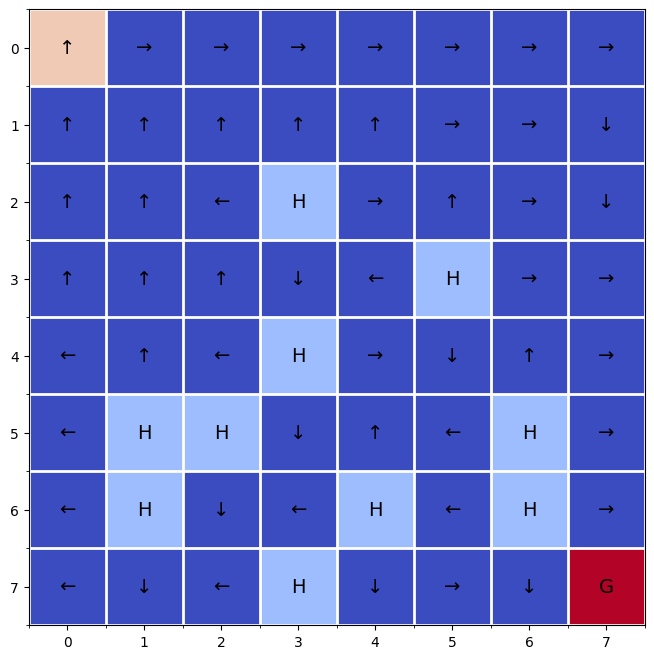

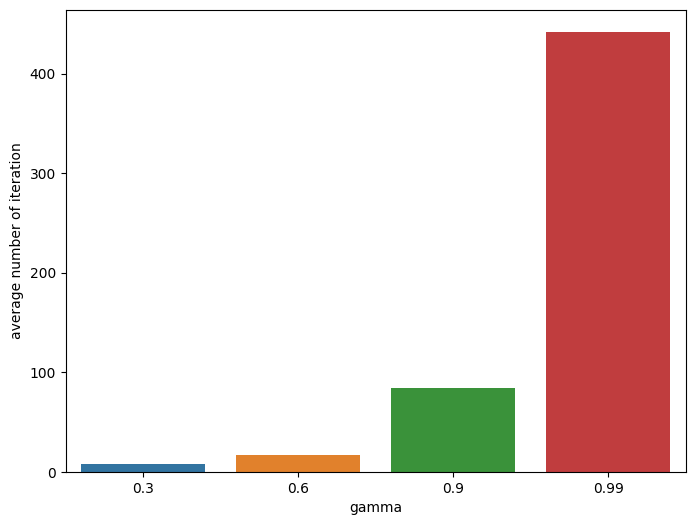

In [10]:
r, p = reward_prob(env)
g1 = []
g2 = []
g3 = []
g4 = []
for gamma in gammas:
    for epsilon in epsilons:
        vi = mdp.ValueIteration(p, r, gamma, epsilon, max_iter=1000)
        vi.run()
        print("gamma = %.2f, epsilon = %.2e, iter = %d" % (gamma, epsilon, vi.iter))
        plot_value(vi.V, (8,8), "8x8")
        plot_policy(vi.policy, (8,8), "8x8")

        if gamma == 0.3:
            g1.append(vi.iter)
        elif gamma == 0.6:
            g2.append(vi.iter)
        elif gamma == 0.9:
            g3.append(vi.iter)
        elif gamma == 0.99:
            g4.append(vi.iter)

g1 = sum(g1)/len(g1)
g2 = sum(g2)/len(g2)
g3 = sum(g3)/len(g3)
g4 = sum(g4)/len(g4)
ave_iter = [g1, g2, g3, g4]

plt.figure(figsize=(8,6))
sns.barplot(x=gammas, y=ave_iter)
plt.xlabel('gamma')
plt.ylabel('average number of iteration')
plt.show()


In [11]:
def Value_Iteration(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    iterations = []
    times = []
    gammas = [0.3, 0.5, 0.6, 0.8, 0.9, 0.96, 0.99]
    for gamma in gammas:
        vi = mdp.ValueIteration(p, r, gamma, epsilon = 1e-2, max_iter=1000)
        vi.run()
        vi.run_stats
        iterations.append([item['Iteration'] for item in vi.run_stats])
        max_vs.append([item['Max V'] for item in vi.run_stats])
        mean_vs.append([item['Mean V'] for item in vi.run_stats])
        errors.append([item['Error'] for item in vi.run_stats])
        times.append([item['Time'] for item in vi.run_stats])

    max_value = max(max_vs)
    print("Best Reward = " + str(max(max_value)))
    
    f, ax = plt.subplots(1,4, figsize=(24,5))
# "Max V"
    for i in range(len(max_vs)):
        ax[0].plot(iterations[i], max_vs[i],
                    alpha=0.6,
                    marker='s', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[0].legend(fontsize=16)
    ax[0].set_xlabel("Number of Iterations")
    ax[0].set_ylabel("Max V")

# "Mean V"
    for i in range(len(mean_vs)):
        ax[1].plot(iterations[i], mean_vs[i],
                    alpha=0.6,
                    marker='o', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[1].legend(fontsize=16)
    ax[1].set_xlabel("Number of Iterations")
    ax[1].set_ylabel("Mean V")
    
# "Error"
    for i in range(len(errors)):
        ax[2].plot(iterations[i], errors[i],
                    alpha=0.6,
                    marker='^', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[2].legend(fontsize=16)
    ax[2].set_xlabel("Number of Iterations")
    ax[2].set_ylabel("Error")

# "Time"
    for i in range(len(times)):
        ax[3].plot(iterations[i], times[i],
                    alpha=0.6,
                    marker='<', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[3].legend(fontsize=16)
    ax[3].set_xlabel("Number of Iterations")
    ax[3].set_ylabel("Time")

    plt.plot()

Best Reward = 0.8775997719241153


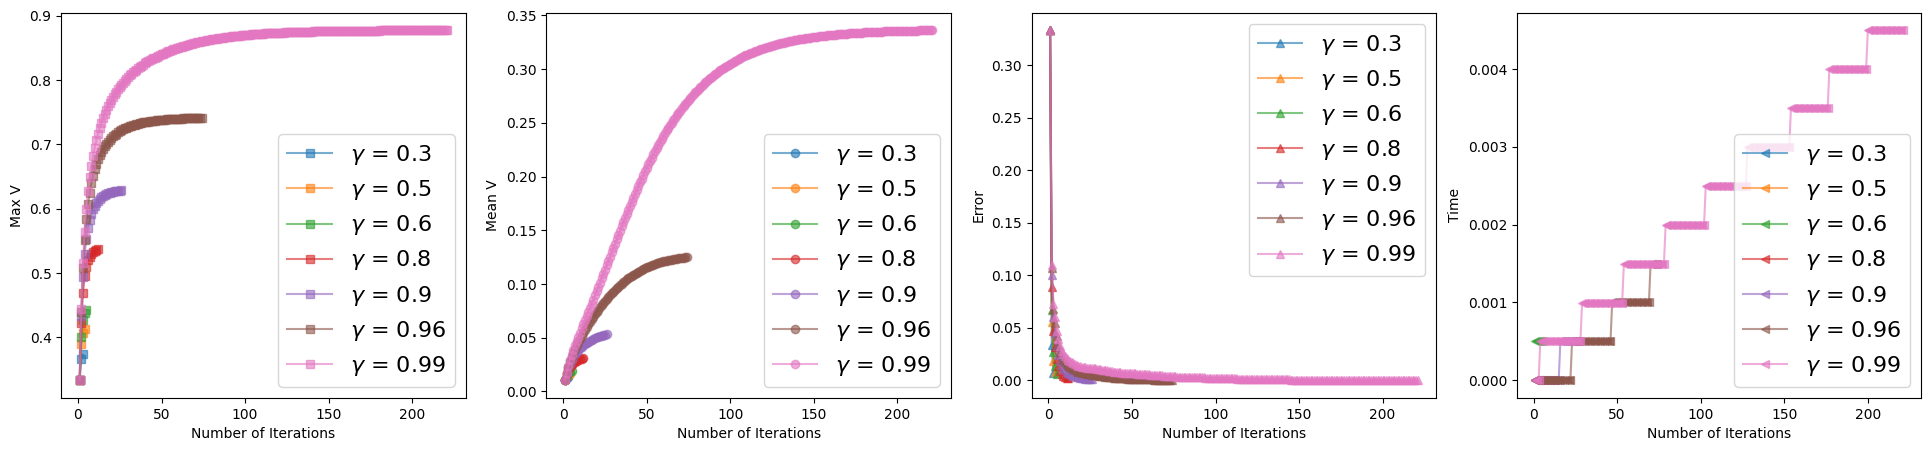

In [12]:
Value_Iteration(p, r)

In [13]:
def Policy_Iteration(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    iterations = []
    times = []
    gammas = [0.3, 0.5, 0.6, 0.8, 0.9, 0.96, 0.99]
    for gamma in gammas:
        pi = mdp.PolicyIteration(p, r, gamma, max_iter=15)
        pi.run()
        pi.run_stats
        iterations.append([item['Iteration'] for item in pi.run_stats])
        max_vs.append([item['Max V'] for item in pi.run_stats])
        mean_vs.append([item['Mean V'] for item in pi.run_stats])
        errors.append([item['Error'] for item in pi.run_stats])
        times.append([item['Time'] for item in pi.run_stats])
        
    max_value = max(max_vs)
    print("Best Reward = " + str(max(max_value)))

    f, ax = plt.subplots(1,4, figsize=(24,5))
# "Max V"
    for i in range(len(max_vs)):
        ax[0].plot(iterations[i], max_vs[i],
                    alpha=0.6,
                    marker='s', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[0].legend(fontsize=16)
    ax[0].set_xlabel("Number of Iterations")
    ax[0].set_ylabel("Max V")

# "Mean V"
    for i in range(len(mean_vs)):
        ax[1].plot(iterations[i], mean_vs[i],
                    alpha=0.6,
                    marker='o', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[1].legend(fontsize=16)
    ax[1].set_xlabel("Number of Iterations")
    ax[1].set_ylabel("Mean V")
    
# "Error"
    for i in range(len(errors)):
        ax[2].plot(iterations[i], errors[i],
                    alpha=0.6,
                    marker='^', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[2].legend(fontsize=16)
    ax[2].set_xlabel("Number of Iterations")
    ax[2].set_ylabel("Error")

# "Time"
    for i in range(len(times)):
        ax[3].plot(iterations[i], times[i],
                    alpha=0.6,
                    marker='<', markersize = 6,
                    label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[3].legend(fontsize=16)
    ax[3].set_xlabel("Number of Iterations")
    ax[3].set_ylabel("Time")

    plt.plot()

Best Reward = 0.8777687393991429


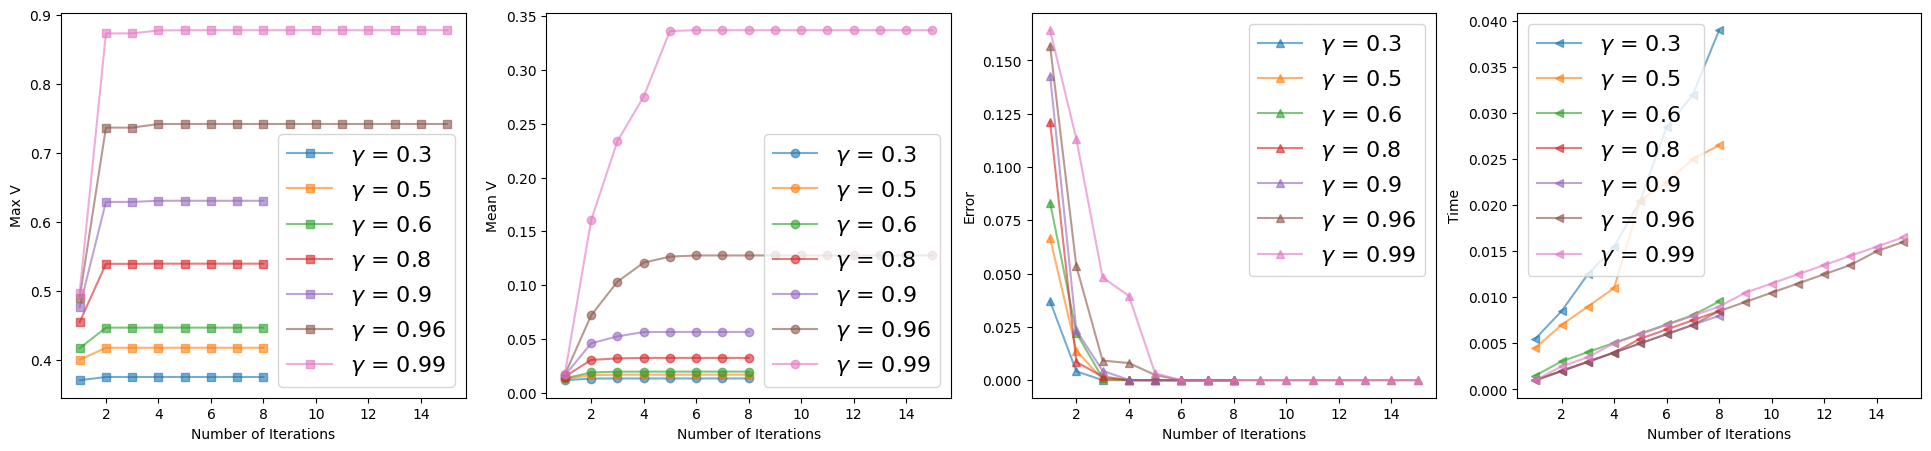

In [14]:
Policy_Iteration(p, r)

gamma = 0.30, iter = 8


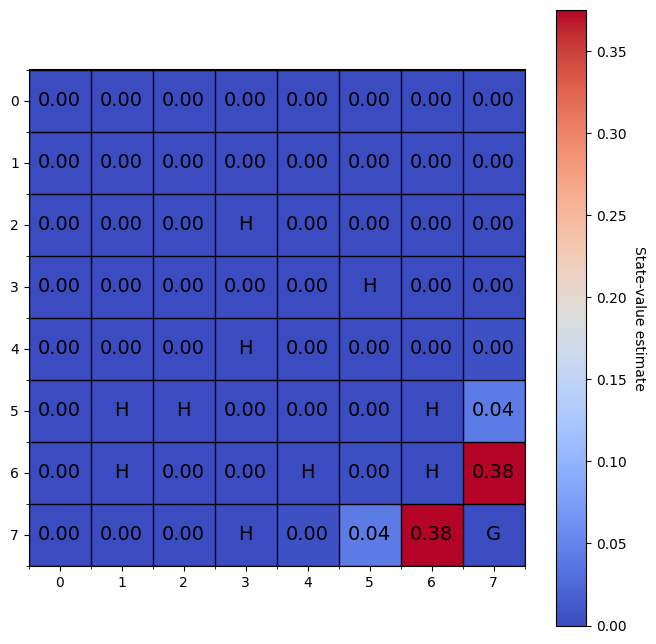

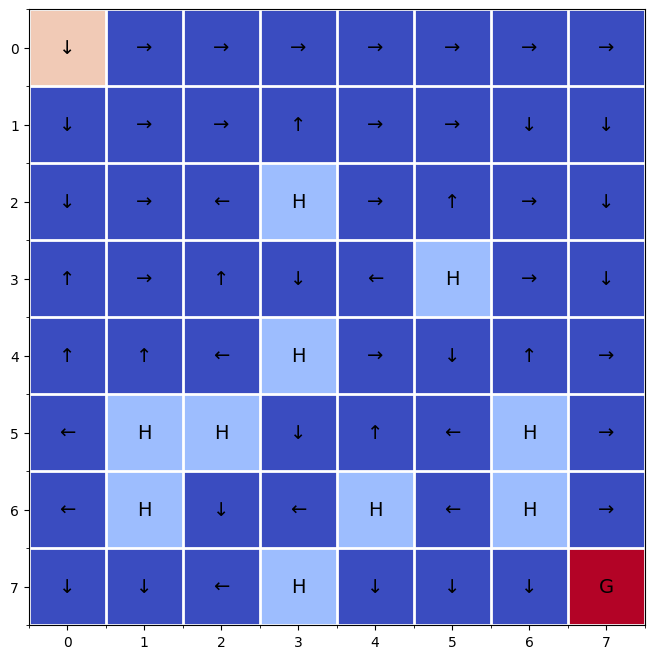

gamma = 0.60, iter = 8


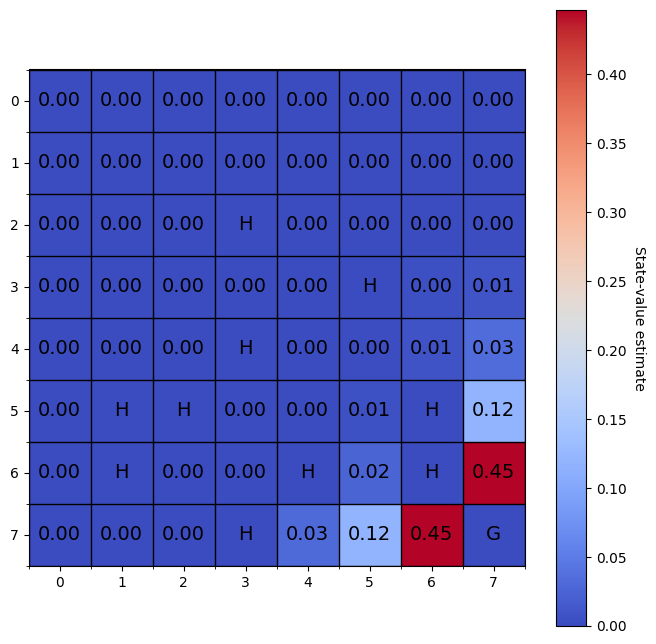

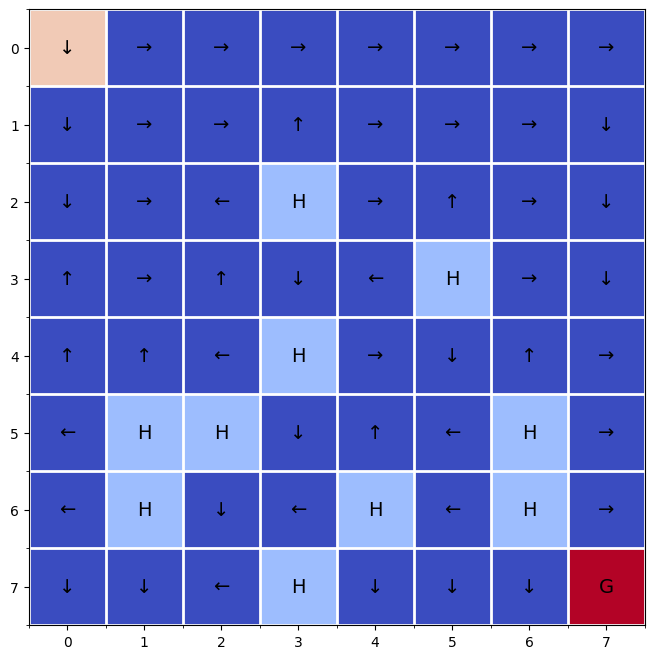

gamma = 0.90, iter = 8


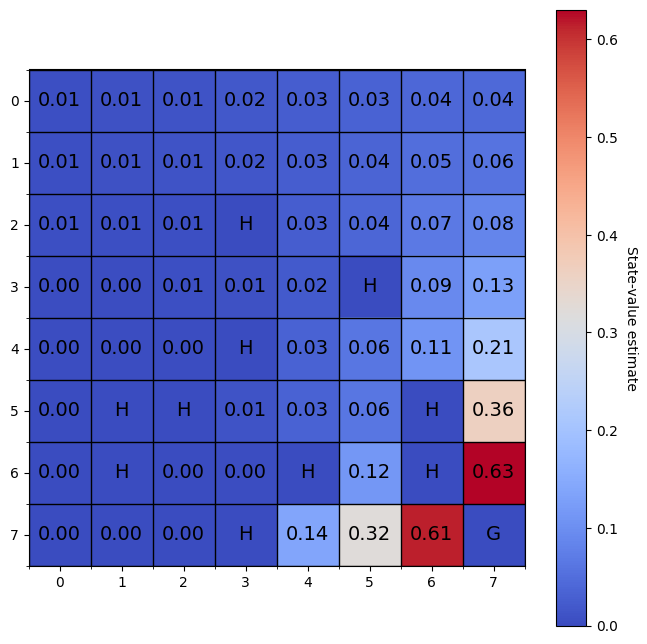

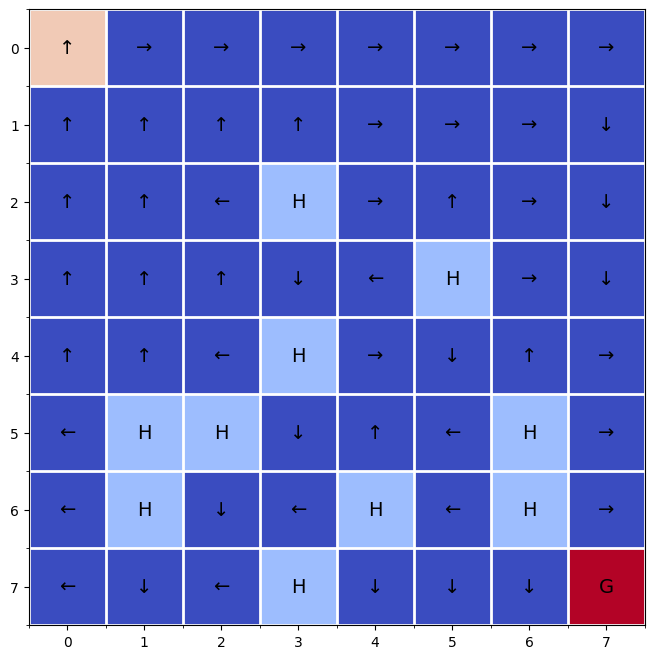

gamma = 0.99, iter = 1000


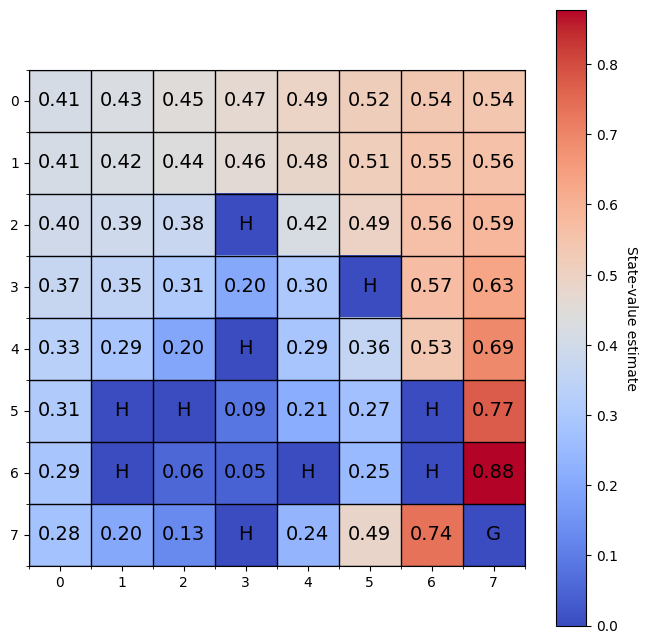

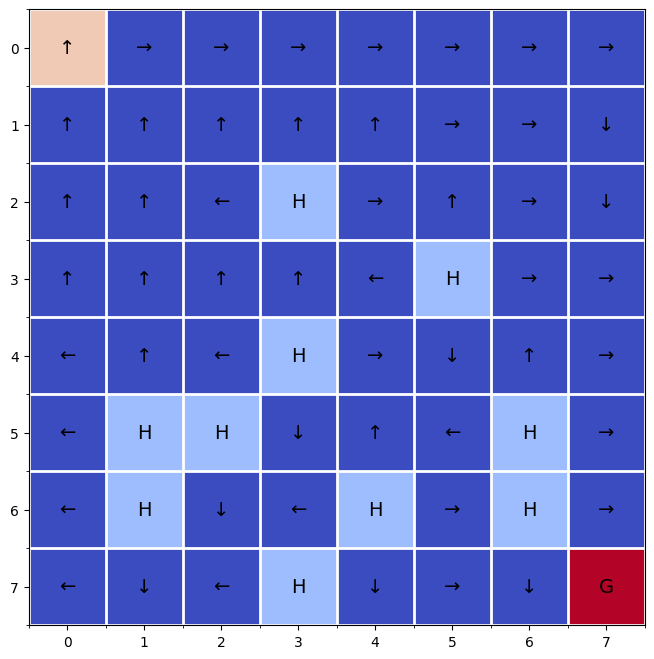

In [15]:
for gamma in gammas:
    pi = mdp.PolicyIteration(p, r, gamma, max_iter=1000)
    pi.run()
    print("gamma = %.2f, iter = %d" % (gamma, pi.iter))
    plot_value(pi.V, (8,8), "8x8")
    plot_policy(pi.policy, (8,8), "8x8")

In [22]:
def QLearning_Gamma(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    iterations = []
    times = []
    gammas = [0.3, 0.5, 0.6, 0.8, 0.9, 0.96, 0.99]
    for gamma in gammas:
        ql = mdp.QLearning(p, r, gamma, alpha = 0.1, alpha_decay = 0.99, epsilon = 1, epsilon_decay = 0.99, n_iter=10000000)
        ql.run()
        ql.run_stats
        iterations.append([item['Iteration'] for item in ql.run_stats])
        max_vs.append([item['Max V'] for item in ql.run_stats])
        mean_vs.append([item['Mean V'] for item in ql.run_stats])
        errors.append([item['Error'] for item in ql.run_stats])
        times.append([item['Time'] for item in ql.run_stats])

    print("Best Reward = " + str(max([item for sublist in max_vs for item in sublist])))
    
    f, ax = plt.subplots(1,4, figsize=(24,5))
# "Max V"   
    for i in range(len(max_vs)):
        ax[0].plot(iterations[i], max_vs[i], alpha=0.6, marker='s', markersize=6, label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[0].legend(fontsize=16)
    ax[0].set_xlabel("Number of Iterations")
    ax[0].set_ylabel("Max V")

# "Mean V"  
    for i in range(len(mean_vs)):
        ax[1].plot(iterations[i], mean_vs[i], alpha=0.6, marker='o', markersize=6, label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[1].legend(fontsize=16)
    ax[1].set_xlabel("Number of Iterations")
    ax[1].set_ylabel("Mean V")

# "Error"
    for i in range(len(errors)):
        ax[2].scatter(iterations[i], errors[i], alpha=0.6, marker='^', s=6, label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[2].legend(fontsize=16)
    ax[2].set_xlabel("Number of Iterations")
    ax[2].set_ylabel("Error")

# "Time"
    for i in range(len(times)):
        ax[3].plot(iterations[i], times[i], alpha=0.6, marker='<', markersize=6, label="$\gamma$ = {}".format(np.round(gammas[i],3)))
    ax[3].legend(fontsize=16)
    ax[3].set_xlabel("Number of Iterations")
    ax[3].set_ylabel("Time")

    plt.plot()

Best Reward = 0.6114423728385714


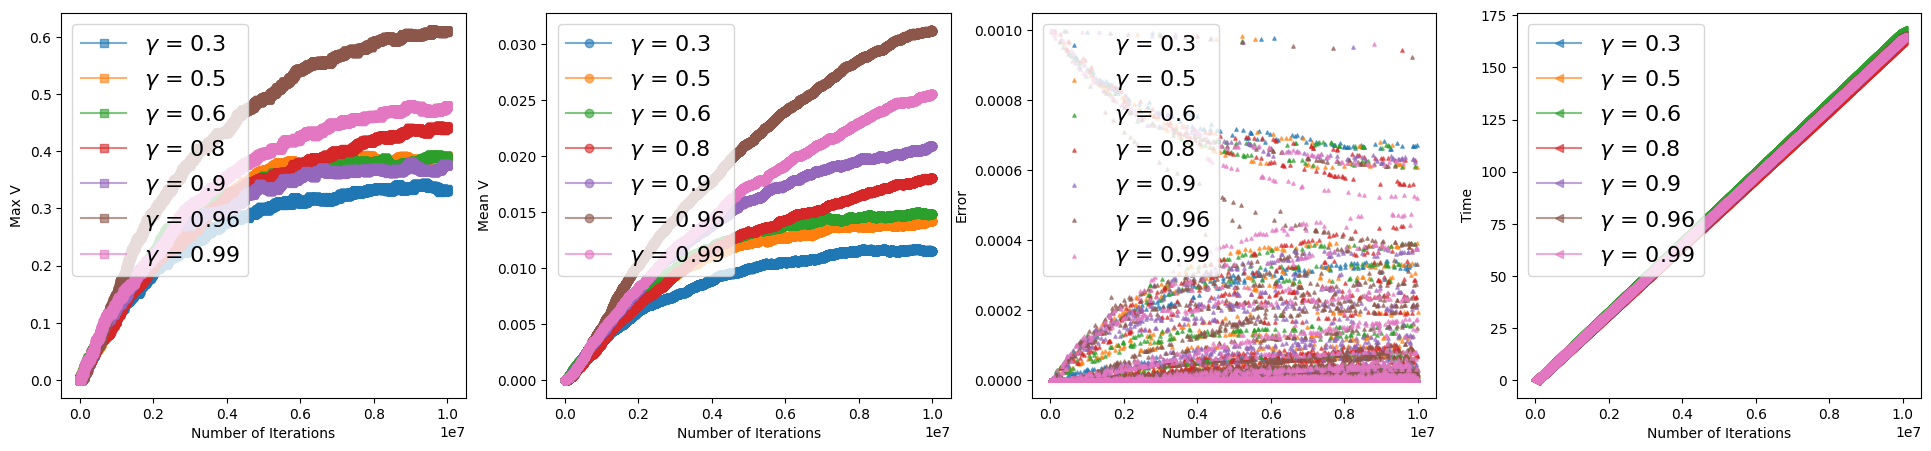

In [23]:
QLearning_Gamma(p, r)

In [24]:
def QLearning_Alpha(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    iterations = []
    times = []
    alphas = [0.1, 0.3, 0.5, 0.7, 0.9]
    for alpha in alphas:
        ql = mdp.QLearning(p, r, 0.99, alpha = alpha, alpha_decay = 0.99, epsilon = 1, epsilon_decay = 0.99, n_iter=10000000)
        ql.run()
        ql.run_stats
        iterations.append([item['Iteration'] for item in ql.run_stats])
        max_vs.append([item['Max V'] for item in ql.run_stats])
        mean_vs.append([item['Mean V'] for item in ql.run_stats])
        errors.append([item['Error'] for item in ql.run_stats])
        times.append([item['Time'] for item in ql.run_stats])
        
    print("Best Reward = " + str(max([item for sublist in max_vs for item in sublist])))
    
    f, ax = plt.subplots(1,4, figsize=(24,6))
# "Max V"
    for i in range(len(max_vs)):
        ax[0].plot(iterations[i], max_vs[i], alpha=0.6, marker='s', markersize=6, label="$\\alpha$ = {}".format(np.round(alphas[i],3)))
    ax[0].legend(fontsize=16)
    ax[0].set_xlabel("Number of Iterations")
    ax[0].set_ylabel("Max V")

# "Mean V"
    for i in range(len(mean_vs)):
        ax[1].plot(iterations[i], mean_vs[i], alpha=0.6, marker='o', markersize=6, label="$\\alpha$ = {}".format(np.round(alphas[i],3)))
    ax[1].legend(fontsize=16)
    ax[1].set_xlabel("Number of Iterations")
    ax[1].set_ylabel("Mean V")

# "Error"
    for i in range(len(errors)):
        ax[2].scatter(iterations[i], errors[i], alpha=0.6, marker='^', s=6, label="$\\alpha$ = {}".format(np.round(alphas[i],3)))
    ax[2].legend(fontsize=16)
    ax[2].set_xlabel("Number of Iterations")
    ax[2].set_ylabel("Error")

# "Time"
    for i in range(len(times)):
        ax[3].plot(iterations[i], times[i], alpha=0.6, marker='<', markersize=6, label="$\\alpha$ = {}".format(np.round(alphas[i],3)))
    ax[3].legend(fontsize=16)
    ax[3].set_xlabel("Number of Iterations")
    ax[3].set_ylabel("Time")

    plt.plot()
    

Best Reward = 0.6705147334820104


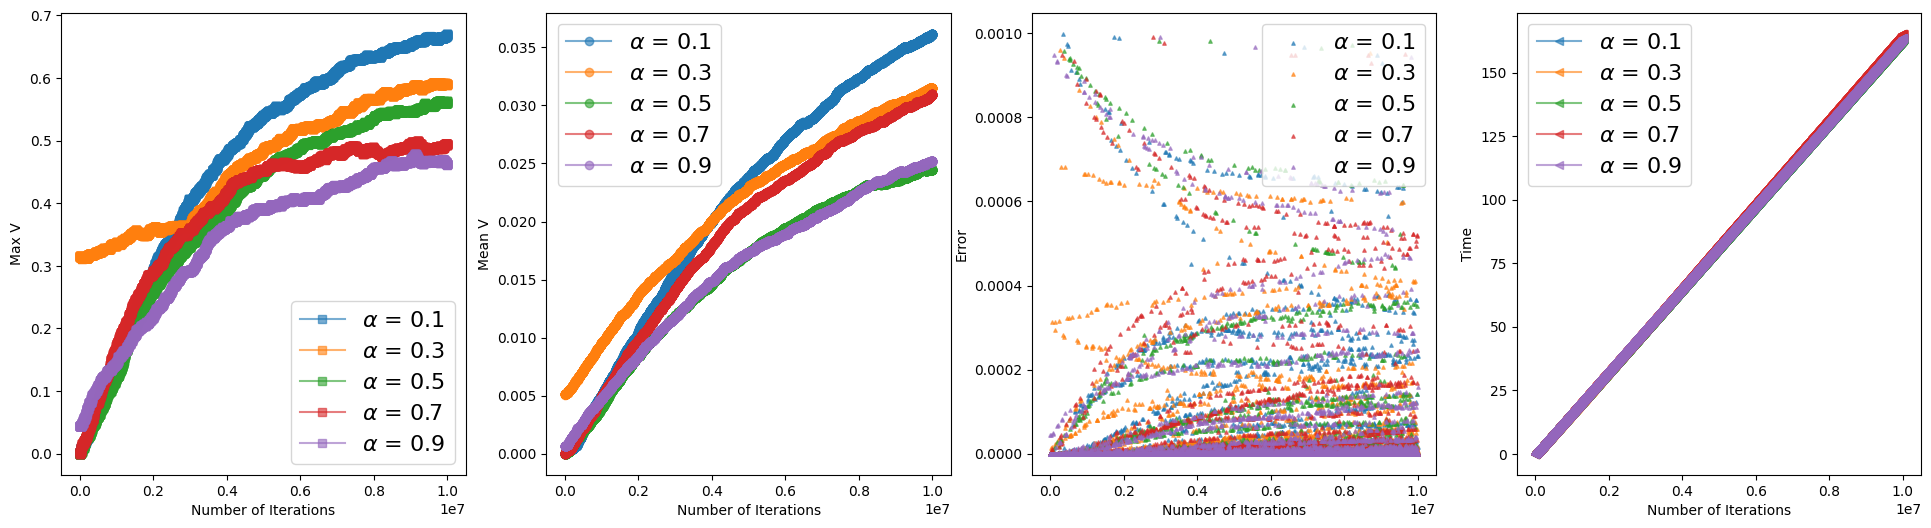

In [25]:
QLearning_Alpha(p, r)

In [26]:
def QLearning_Epsilon(p, r):
    max_vs = []
    mean_vs = []
    errors = []
    iterations = []
    times = []
    epsilons = [0, 0.2, 0.4, 0.6, 0.8, 1]
    for epsilon in epsilons:
        ql = mdp.QLearning(p, r, gamma=0.99, alpha=0.1, alpha_decay=0.99, epsilon=epsilon, epsilon_decay=0.99, n_iter=10000000)
        ql.run()
        ql.run_stats
        iterations.append([item['Iteration'] for item in ql.run_stats])
        max_vs.append([item['Max V'] for item in ql.run_stats])
        mean_vs.append([item['Mean V'] for item in ql.run_stats])
        errors.append([item['Error'] for item in ql.run_stats])
        times.append([item['Time'] for item in ql.run_stats])

    print("Best Reward = " + str(max([item for sublist in max_vs for item in sublist])))
    
    f, ax = plt.subplots(1,4, figsize=(24,5))

# "Max V"
    for i in range(len(max_vs)):
        ax[0].plot(iterations[i], max_vs[i], alpha=1, marker='s', markersize=6, label="$\epsilon$= {}".format(np.round(epsilons[i],3)))
    ax[0].legend(fontsize=16)
    ax[0].set_xlabel("Number of Iterations")
    ax[0].set_ylabel("Max V", fontsize=16)

# "Mean V" 
    for i in range(len(mean_vs)):
        ax[1].plot(iterations[i], mean_vs[i], alpha=1, marker='o', markersize=6, label="$\epsilon$= {}".format(np.round(epsilons[i],3)))
    ax[1].legend(fontsize=16)
    ax[1].set_xlabel("Number of Iterations")
    ax[1].set_ylabel("Mean V", fontsize=16)

# "Error"
    for i in range(len(errors)):
        ax[2].scatter(iterations[i], errors[i], alpha=1, marker='^', s=6, label="$\epsilon$ = {}".format(np.round(epsilons[i],3)))
    ax[2].legend(fontsize=16)
    ax[2].set_xlabel("Number of Iterations")
    ax[2].set_ylabel("Error")

# "Time"
    for i in range(len(times)):
        ax[3].plot(iterations[i], times[i], alpha=1, marker='<', markersize=6, label="$\epsilon$ = {}".format(np.round(epsilons[i],3)))
    ax[3].legend(fontsize=16)
    ax[3].set_xlabel("Number of Iterations")
    ax[3].set_ylabel("Time")

    plt.plot()

Best Reward = 0.48250739455002273


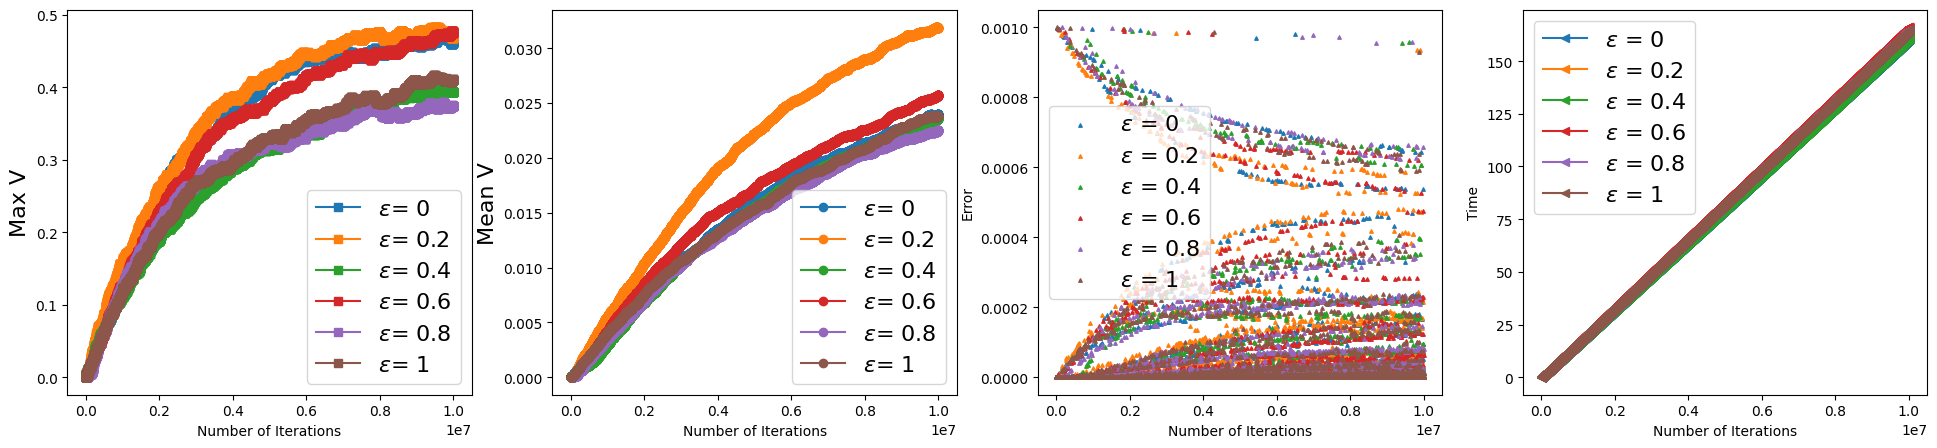

In [27]:
QLearning_Epsilon(p, r)